# Lockdown intensity through public bikes mobility data

With this analysis I would like to gain insights on the intensity of the lockdown in April at Oslo, through data on the use of public bikes. In general, the harder the lockdown, the fewer the people travelling. Therefore we should be able to assess how strong the restrictions are, and how closely people are following them, by looking at mobility data.

In this analysis we are going to look at data about the use of the public shared bikes provided by the city of Oslo. We will start from a very simple analysis: by counting the number of rides and the total time travelled.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

df_19 = pd.read_csv('04-2019.csv')
df_20 = pd.read_csv('04-2020.csv')
df_19.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2019-04-02 22:18:47.926000+00:00,2019-04-02 22:24:25.427000+00:00,337,401,Schous plass,nærmest Thorvald Meyers gate,"59,920259","10,760629",381,Grønlands torg,ved Tøyenbekken,"59,91252","10,76224"
1,2019-04-02 22:25:54.203000+00:00,2019-04-02 22:27:36.114000+00:00,101,556,Pilestredet,ved Sporveisgata,"59,9262242","10,7296246",556,Pilestredet,ved Sporveisgata,"59,9262242","10,7296246"
2,2019-04-02 22:26:39.308000+00:00,2019-04-02 22:31:59.445000+00:00,320,561,Kirkeveien,nord for Gørbitz' gate,"59,9335582","10,7264261",471,Marienlyst,i Suhms gate,"59,932454","10,721769"
3,2019-04-03 03:09:58.992000+00:00,2019-04-03 03:12:00.589000+00:00,121,393,Hans Nielsen Hauges plass,Mellom Åsengata og Nordkappgata,"59,939244","10,774319",393,Hans Nielsen Hauges plass,Mellom Åsengata og Nordkappgata,"59,939244","10,774319"
4,2019-04-03 03:10:02.415000+00:00,2019-04-03 03:14:44.537000+00:00,282,597,Fredensborg,ved rundkjøringen,"59,920995","10,750358",557,Akersgata,ved Grensen,"59,9141971","10,7428828"


In [2]:
rows_2019,cols_2019 = df_19.shape
rows_2020,cols_2020 = df_20.shape
total_rides_variation = (rows_2020 - rows_2019) / rows_2019
total_rides_variation

-0.5019154649934454

Compared to 2019, there have been 50.19% fewer rides in 2020.

In [3]:
df_19.columns

Index(['started_at', 'ended_at', 'duration', 'start_station_id',
       'start_station_name', 'start_station_description',
       'start_station_latitude', 'start_station_longitude', 'end_station_id',
       'end_station_name', 'end_station_description', 'end_station_latitude',
       'end_station_longitude'],
      dtype='object')

In [4]:
df_19['duration']

0          337
1          101
2          320
3          121
4          282
5          658
6          214
7          384
8          857
9          339
10        6683
11        1004
12         546
13         608
14         391
15        1028
16         872
17         217
18         593
19         224
20         246
21         405
22         284
23         565
24         185
25         252
26         207
27         718
28         273
29         557
          ... 
235683     693
235684     432
235685    4576
235686     156
235687     627
235688     755
235689     827
235690     407
235691     950
235692     378
235693    1104
235694    1033
235695     542
235696     785
235697     541
235698    2382
235699     293
235700     979
235701     397
235702    1084
235703     622
235704     313
235705     707
235706     287
235707     597
235708     647
235709     744
235710     100
235711     562
235712     284
Name: duration, Length: 235713, dtype: int64

In [5]:
total_duration_2019 = df_19['duration'].sum()
total_duration_2020 = df_20['duration'].sum()
total_duration_variation = (total_duration_2020 - total_duration_2019) / total_duration_2019
total_duration_variation

-0.45972917064790036

Compared to 2019, the total time travelled has shrinked by 45.97%.

In [6]:
df_19['duration'].describe()

count    2.357130e+05
mean     8.875432e+02
std      6.237237e+03
min      6.100000e+01
25%      3.300000e+02
50%      5.310000e+02
75%      8.890000e+02
max      1.135407e+06
Name: duration, dtype: float64

In [7]:
df_20['duration'].describe()

count    117405.000000
mean        962.715464
std        1283.649437
min          61.000000
25%         384.000000
50%         637.000000
75%        1107.000000
max      183081.000000
Name: duration, dtype: float64

From the description of the rides durations, we can see that actually the time travelled per ride has increased in 2020. Therefore the decrease in total time travelled is caused exclusively by the fewer total rides.

In [8]:
df_19['started_at'] = pd.to_datetime(df_19['started_at'])
df_20['started_at'] = pd.to_datetime(df_20['started_at'])
df_19_time = df_19.set_index('started_at')
df_20_time = df_20.set_index('started_at')
df_19_time.head()

,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
started_at,,,,,,,,,,,,
2019-04-02 22:18:47.926000+00:00,2019-04-02 22:24:25.427000+00:00,337,401,Schous plass,nærmest Thorvald Meyers gate,"59,920259","10,760629",381,Grønlands torg,ved Tøyenbekken,"59,91252","10,76224"
2019-04-02 22:25:54.203000+00:00,2019-04-02 22:27:36.114000+00:00,101,556,Pilestredet,ved Sporveisgata,"59,9262242","10,7296246",556,Pilestredet,ved Sporveisgata,"59,9262242","10,7296246"
2019-04-02 22:26:39.308000+00:00,2019-04-02 22:31:59.445000+00:00,320,561,Kirkeveien,nord for Gørbitz' gate,"59,9335582","10,7264261",471,Marienlyst,i Suhms gate,"59,932454","10,721769"
2019-04-03 03:09:58.992000+00:00,2019-04-03 03:12:00.589000+00:00,121,393,Hans Nielsen Hauges plass,Mellom Åsengata og Nordkappgata,"59,939244","10,774319",393,Hans Nielsen Hauges plass,Mellom Åsengata og Nordkappgata,"59,939244","10,774319"
2019-04-03 03:10:02.415000+00:00,2019-04-03 03:14:44.537000+00:00,282,597,Fredensborg,ved rundkjøringen,"59,920995","10,750358",557,Akersgata,ved Grensen,"59,9141971","10,7428828"


In [9]:
df_19_time.index

DatetimeIndex(['2019-04-02 22:18:47.926000+00:00',
               '2019-04-02 22:25:54.203000+00:00',
               '2019-04-02 22:26:39.308000+00:00',
               '2019-04-03 03:09:58.992000+00:00',
               '2019-04-03 03:10:02.415000+00:00',
               '2019-04-03 03:16:21.557000+00:00',
               '2019-04-03 03:39:11.948000+00:00',
               '2019-04-03 03:43:38.513000+00:00',
               '2019-04-03 03:46:23.126000+00:00',
               '2019-04-03 03:50:36.147000+00:00',
               ...
               '2019-04-29 21:12:33.762000+00:00',
               '2019-04-29 21:15:32.781000+00:00',
               '2019-04-29 21:15:46.763000+00:00',
               '2019-04-29 21:16:55.822000+00:00',
               '2019-04-29 21:26:12.063000+00:00',
               '2019-04-29 21:29:19.642000+00:00',
               '2019-04-29 21:35:52.924000+00:00',
               '2019-04-29 21:45:11.161000+00:00',
               '2019-04-29 21:48:59.960000+00:00',
            

In [10]:
df_19_counts = df_19_time.resample('D').count()
df_20_counts = df_20_time.resample('D').count()
df_19_counts.index = df_19_counts.index.shift(periods=365)
df_19_counts['year'] = '2019'
df_20_counts['year'] = '2020'
df_counts = pd.concat([df_19_counts,df_20_counts],sort=True)

/home/alle/.local/lib/python3.5/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/home/alle/.local/lib/python3.5/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


Text(0.5, 1.0, 'Total bike rides per month day in April')

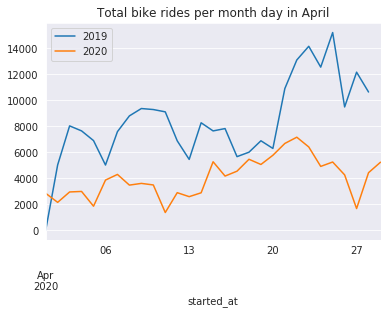

In [11]:
df_19_counts.iloc[:,0].plot()
df_20_counts.iloc[:,0].plot()
plt.legend(['2019','2020'])
plt.title('Total bike rides per month day in April')

If we plot alongside the 2019 and 2020 data, we can see that almost every day of the month there have been fewer rides in 2020. In particular, the gap narrows towards the 20th of April, and then widens again. This may coincide with naive considerations, because the week 12-19 was Easter week in 2020. At the eye test we had the impression that people were going out more than in the past weeks.

However, this study is not conclusive: before drawing conclusions we should account for the weather and for the day of the week.

In [12]:
df_variations = (df_20_counts.iloc[:,0] - df_19_counts.iloc[:,0]) / df_19_counts.iloc[:,0]
df_variations.head()

started_at
2020-04-01 00:00:00+00:00    946.000000
2020-04-02 00:00:00+00:00     -0.572964
2020-04-03 00:00:00+00:00     -0.633101
2020-04-04 00:00:00+00:00     -0.609373
2020-04-05 00:00:00+00:00     -0.731902
Freq: D, Name: ended_at, dtype: float64

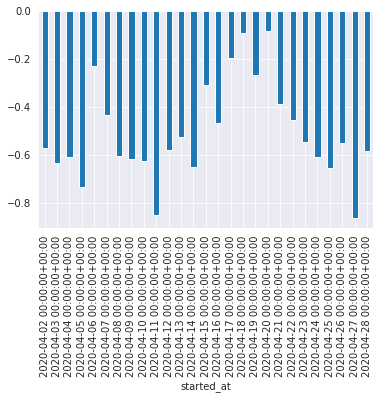

In [13]:
df_variations.iloc[1:-1].plot(kind='bar')

As we saw in the line chart, the relative variation compared to 2019 has been slimmer around the 20th of April, and near the end of the month got back to levels similar to the week 5-12.

This brief study is able to tell detect a spike in mobility in the period 12th-19th of April, which was Easter week in 2020. This surely denote the fact that in those days the situation was similar to 2019, so it may hint at an ease of the lockdown, or at a less strict following of the lockdown rules by the population. Even with simple mobility data, we can see a clear increase in mobility to levels similar to 2019.

This is not conclusive on the _reasons_ though. We would be able to say more about this by plugging in weather data, the day of the week and the days when restrictions were lifted.